In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches

import numpy as np
import math
import glob
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import folium

import warnings
warnings.filterwarnings("ignore")

In [ ]:
"""
# Folder Path on Google Drive
folder_path = "/content/drive/MyDrive/Colab/NU/IE6200/trip_data/"

# Get all CSV files in the folder
csv_files = glob.glob(folder_path + "*.csv")

# Initialize an empty list to store dataframes
dfs = []

# Loop over each file with tqdm progress bar, load it, rename columns, and append to the list
for file in tqdm(csv_files, desc="Loading and Processing CSV Files"):
    df = pd.read_csv(file)
    # Rename the columns
    df = df.rename(columns={
        "member_casual": "rider_type",
        "rideable_type": "bike_type"
    })
    # Replace 'electric_bike' with 'electric' and 'classic_bike' with 'traditional'
    df['bike_type'] = df['bike_type'].replace({'electric_bike': 'electric', 'classic_bike': 'traditional'})
    # Append to the list of dataframes
    dfs.append(df)

# Combine all dataframes into one
all_df = pd.concat(dfs, ignore_index=True)

# Sort the combined DataFrame by "started_at" column
all_df = all_df.sort_values(by="started_at").reset_index(drop=True)
"""

'\n# Folder Path on Google Drive\nfolder_path = "/content/drive/MyDrive/Colab/NU/IE6200/trip_data/"\n\n# Get all CSV files in the folder\ncsv_files = glob.glob(folder_path + "*.csv")\n\n# Initialize an empty list to store dataframes\ndfs = []\n\n# Loop over each file with tqdm progress bar, load it, rename columns, and append to the list\nfor file in tqdm(csv_files, desc="Loading and Processing CSV Files"):\n    df = pd.read_csv(file)\n    # Rename the columns\n    df = df.rename(columns={\n        "member_casual": "rider_type",\n        "rideable_type": "bike_type"\n    })\n    # Replace \'electric_bike\' with \'electric\' and \'classic_bike\' with \'traditional\'\n    df[\'bike_type\'] = df[\'bike_type\'].replace({\'electric_bike\': \'electric\', \'classic_bike\': \'traditional\'})\n    # Append to the list of dataframes\n    dfs.append(df)\n\n# Combine all dataframes into one\nall_df = pd.concat(dfs, ignore_index=True)\n\n# Sort the combined DataFrame by "started_at" column\nall_df 

In [ ]:
# Load data to Pandas dataFrame
folder_path = "/content/drive/MyDrive/Colab/NU/IE6200/trip_data/"
all_df = pd.read_csv(folder_path + "all_trips.csv")

# Replace 'electric_bike' with 'electric' and 'classic_bike' with 'traditional'
all_df['bike_type'] = all_df['bike_type'] \
                        .replace({'electric_bike': 'electric',
                                  'classic_bike': 'traditional'})

In [ ]:
all_df.shape

(4333153, 13)

In [ ]:
# Assign combined_df as a deep copy of all_df
combined_df = all_df.copy()

In [ ]:
combined_df.dtypes

,0
ride_id,object
bike_type,object
started_at,object
ended_at,object
start_station_name,object
start_station_id,object
end_station_name,object
end_station_id,object
start_lat,float64
start_lng,float64


In [ ]:
# Convert started_at and ended_at columns to datetime
combined_df["started_at"] = pd.to_datetime(combined_df["started_at"], errors='coerce')
combined_df["ended_at"] = pd.to_datetime(combined_df["ended_at"], errors='coerce')

# Check the data types after conversion
combined_df[["started_at", "ended_at"]].dtypes

,0
started_at,datetime64[ns]
ended_at,datetime64[ns]


In [ ]:
# Function to check for fractional seconds
def check_fractional_seconds(df, *features):
    fractional_seconds = df[df[features[0]].astype(str).str.contains(r"\.\d+")]

    if fractional_seconds.empty:
        print("No rows with fractional seconds found.")
    else:
        print(fractional_seconds[[*features]].head())

# Check for fractional seconds
check_fractional_seconds(combined_df, 'started_at', 'ended_at')

No rows with fractional seconds found.


In [ ]:
# Identify rows where conversion to datetime failed
invalid_dates = combined_df[combined_df["started_at"].isna() | combined_df["ended_at"].isna()]
if invalid_dates.empty:
    print("No invalid dates found.")
else:
    # Display rows with invalid dates
    print(invalid_dates[["started_at", "ended_at"]].head())

num_invalid_dates = len(combined_df[combined_df["started_at"].isna() | \
                                    combined_df["ended_at"].isna()])

print(f"\nNumber of rows with invalid dates: {num_invalid_dates}.")

No invalid dates found.

Number of rows with invalid dates: 0.


In [ ]:
# Missing values
missing_values = combined_df.isnull().sum()
missing_values

,0
ride_id,0
bike_type,0
started_at,0
ended_at,0
start_station_name,1238
start_station_id,1238
end_station_name,7804
end_station_id,7999
start_lat,0
start_lng,0


In [ ]:
# Remove rows with any missing values
combined_df = combined_df.dropna()

In [ ]:
# Calculate trip duration in minutes and filter invalid durations (<= 0 or > 120 minutes)
combined_df["trip_duration_minutes"] = (combined_df["ended_at"] - combined_df["started_at"]).dt.total_seconds() / 60

combined_df['trip_duration_minutes'] = combined_df['trip_duration_minutes'].where(combined_df['trip_duration_minutes'].between(0, 120), None)

trip_duration_minutes = combined_df['trip_duration_minutes']

# Print count of invalid durations and filter rows
print(f"Unreasonable durations: {(combined_df['trip_duration_minutes'].isna()).sum()}")
combined_df = combined_df[combined_df['trip_duration_minutes'].notna()]

Unreasonable durations: 20396


In [ ]:
def validate_station_mappings(dataframe):
    """
    Validate Station Name-to-ID mappings for both start and end stations.

    This function checks for inconsistencies between station names and station IDs by identifying
    cases where a station name is associated with multiple station IDs or where a station ID is
    associated with multiple station names. The results are printed to the console.

    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing bike trip data with station names and IDs.
    """

    # Create dictionaries to map start station names to IDs and start station IDs to names
    start_name_to_ids = dataframe.groupby("start_station_name")["start_station_id"].unique().to_dict()
    start_id_to_names = dataframe.groupby("start_station_id")["start_station_name"].unique().to_dict()

    # Create dictionaries to map end station names to IDs and end station IDs to names
    end_name_to_ids = dataframe.groupby("end_station_name")["end_station_id"].unique().to_dict()
    end_id_to_names = dataframe.groupby("end_station_id")["end_station_name"].unique().to_dict()

    # Check for mismatches in start stations (name to multiple IDs)
    print("Start Station Names Mapping to Multiple IDs:")
    if any(len(ids) > 1 for ids in start_name_to_ids.values()):
        for name, ids in start_name_to_ids.items():
            if len(ids) > 1:
                print(f"{name}: {list(ids)} (Instances: {len(ids)})")
    else:
        print("nil")

    # Check for mismatches in start stations (ID to multiple names)
    print("\nStart Station IDs Mapping to Multiple Names:")
    if any(len(names) > 1 for names in start_id_to_names.values()):
        for station_id, names in start_id_to_names.items():
            if len(names) > 1:
                print(f"{station_id}: {list(names)} (Instances: {len(names)})")
    else:
        print("nil")

    # Check for mismatches in end stations (name to multiple IDs)
    print("\nEnd Station Names Mapping to Multiple IDs:")
    if any(len(ids) > 1 for ids in end_name_to_ids.values()):
        for name, ids in end_name_to_ids.items():
            if len(ids) > 1:
                print(f"{name}: {list(ids)} (Instances: {len(ids)})")
    else:
        print("nil")

    # Check for mismatches in end stations (ID to multiple names)
    print("\nEnd Station IDs Mapping to Multiple Names:")
    if any(len(names) > 1 for names in end_id_to_names.values()):
        for station_id, names in end_id_to_names.items():
            if len(names) > 1:
                print(f"{station_id}: {list(names)} (Instances: {len(names)})")
    else:
        print("nil")

validate_station_mappings(combined_df)

Start Station Names Mapping to Multiple IDs:
Somerville Hospital: ['S32020', 'S32052'] (Instances: 2)
Tremont St at Court St: ['A32046', 'A32058'] (Instances: 2)

Start Station IDs Mapping to Multiple Names:
A32024: ['Staniford at Merrimac', 'Staniford St at Merrimac St'] (Instances: 2)
A32046: ['Tremont St at Court St', 'Canal St. at Causeway St.', 'Canal St at Causeway St'] (Instances: 3)
A32058: ['Tremont St. at Court St.', 'Tremont St at Court St'] (Instances: 2)
B32038: ['Chestnut Hill Ave. at Ledgemere Road', 'Chestnut Hill Ave at Ledgemere Rd'] (Instances: 2)
C32054: ['Shawmut Ave. at Herald St.', 'Shawmut Ave at Herald St'] (Instances: 2)
C32109: ['Centre St. at Allandale St.', 'Centre St at Allandale St'] (Instances: 2)
E32003: ['Hyde Square - Barbara St at Centre St', 'Hyde Square - Centre St at Perkins St'] (Instances: 2)
L32007: ['Swan Pl. at Minuteman Bikeway', 'Swan Place at Minuteman Bikeway'] (Instances: 2)
L32010: ['Medford St. at Warren St.', 'Medford St at Warren St'

In [ ]:
# Delete trips starting or ending at station ID "S32020" (this station does not exist)
start_S32020 = combined_df["start_station_id"].value_counts().get("S32020", 0)
end_S32020 = combined_df["end_station_id"].value_counts().get("S32020", 0)

S32020_mismatch = start_S32020 + end_S32020
print(f"{S32020_mismatch} of the trips start or end at station S32020.")

combined_df = combined_df[~((combined_df["start_station_id"] == "S32020") |
                            (combined_df["end_station_id"] == "S32020"))]

137 of the trips start or end at station S32020.


In [ ]:
# Count instances of "A32046" under start and end station IDs for the name "Tremont St at Court St"
count_start = combined_df[(combined_df["start_station_id"] == "A32046") &
                          (combined_df["start_station_name"] == "Tremont St at Court St")].shape[0]

count_end = combined_df[(combined_df["end_station_id"] == "A32046") &
                        (combined_df["end_station_name"] == "Tremont St at Court St")].shape[0]

# Total instances
total_count = count_start + count_end
print(f"Total instances of station ID A32046 mismatched with Tremont St at Court St: {total_count}")

# Update start_station_name and end_station_name for "A32046" instances
# Station ID A32046 is for "Canal St at Causeway St" not "Tremont St at Court St"

combined_df.loc[(combined_df["start_station_id"] == "A32046") &
                (combined_df["start_station_name"] == "Tremont St at Court St"),
                "start_station_name"] = "Canal St at Causeway St"

combined_df.loc[(combined_df["end_station_id"] == "A32046") &
                (combined_df["end_station_name"] == "Tremont St at Court St"),
                "end_station_name"] = "Canal St at Causeway St"

Total instances of station ID A32046 mismatched with Tremont St at Court St: 34


In [ ]:
def update_station_names(dataframe, old_name, new_name):
    """
    Update station names in both start and end station columns of the DataFrame.

    This function replaces occurrences of the specified old station name with the new station name
    in both "start_station_name" and "end_station_name" columns of the DataFrame.

    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing bike trip data with station names.
        old_name (str): The old station name to be replaced.
        new_name (str): The new station name to replace with.
    """
    # Update both start and end station names
    dataframe.loc[dataframe["start_station_name"] == old_name, "start_station_name"] = new_name
    dataframe.loc[dataframe["end_station_name"] == old_name, "end_station_name"] = new_name

# List of changes to be made
changes = [
    ["Canal St. at Causeway St.", "Canal St at Causeway St"],
    ["Tremont St. at Court St.", "Tremont St at Court St"],
    ["Chestnut Hill Ave. at Ledgemere Road", "Chestnut Hill Ave at Ledgemere Rd"],
    ["Centre St. at Allandale St.", "Centre St at Allandale St"],
    ["Hyde Square - Barbara St at Centre St", "Hyde Square - Centre St at Perkins St"],
    ["Swan Pl. at Minuteman Bikeway", "Swan Place at Minuteman Bikeway"],
    ["CambridgeSide Galleria - CambridgeSide PL at Land Blvd", "Cambridgeside Pl at Land Blvd"],
    ["Summer St at Quincy St", "Somerville Hospital"],
    ["Everett Square (Broadway at Chelsea St)", "Everett Square (Broadway at Norwood St)"],
    ["Damrell st at Old Colony Ave", "Damrell St at Old Colony Ave"],
    ["Staniford at Merrimac", "Staniford St at Merrimac St"],
    ["Shawmut Ave. at Herald St.", "Shawmut Ave at Herald St"],
    ["Medford St. at Warren St.", "Medford St at Warren St"]
]

# Applying the changes to the DataFrame
for old_name, new_name in changes:
    update_station_names(combined_df, old_name, new_name)

# Confirmation message
print("Station names updated successfully.")

Station names updated successfully.


In [ ]:
# Check for mismatch again
validate_station_mappings(combined_df)

Start Station Names Mapping to Multiple IDs:
nil

Start Station IDs Mapping to Multiple Names:
nil

End Station Names Mapping to Multiple IDs:
nil

End Station IDs Mapping to Multiple Names:
A32046: ['Canal St\xa0at\xa0Causeway\xa0St', 'Canal St at Causeway St'] (Instances: 2)


In [ ]:
"""
The \xa0 character is the Unicode representation for a non-breaking space (NBSP). This character
is different from a regular space ( " " , Unicode U+0020 ) although they appear the same.
"""

# Standardize station names for A32046
standard_name = "Canal St at Causeway St"

# Identify and replace the inconsistent names
combined_df.loc[
    (combined_df["end_station_id"] == "A32046") &
    (combined_df["end_station_name"].isin(["Canal St at Causeway St",
    "Canal St\xa0at\xa0Causeway\xa0St"])), "end_station_name"] = standard_name

# Final check for mismatch
validate_station_mappings(combined_df)

Start Station Names Mapping to Multiple IDs:
nil

Start Station IDs Mapping to Multiple Names:
nil

End Station Names Mapping to Multiple IDs:
nil

End Station IDs Mapping to Multiple Names:
nil


Number of trips that started and ended at the same station: 155568


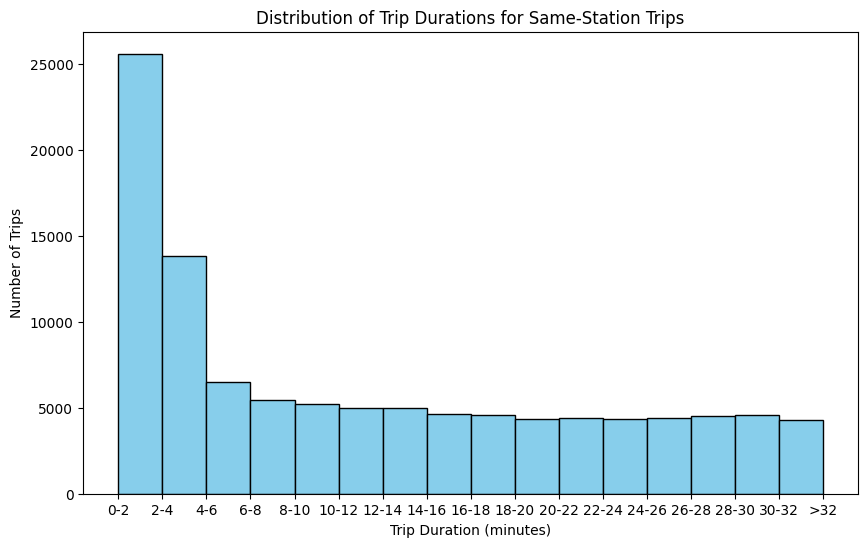

In [ ]:
# Filter trips where the start and end stations are the same
same_station_trips = combined_df[combined_df['start_station_id'] == combined_df['end_station_id']]

# Print the number of such trips
print(f"Number of trips that started and ended at the same station: {len(same_station_trips)}")

# Define custom bins for the histogram
bins = np.arange(0, 34, 2)
bins = np.append(bins, [np.inf])  # Adding a final bin for durations >30

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(same_station_trips['trip_duration_minutes'], bins=bins, color='skyblue', edgecolor='black')
plt.title('Distribution of Trip Durations for Same-Station Trips')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Number of Trips')
plt.xticks(ticks=bins[:-1], labels=[f"{int(b)}-{int(bins[i+1])}" if i < len(bins) - 2 else ">32" for i, b in enumerate(bins[:-1])])

plt.show()

In [ ]:
# Remove same-station trips with duration < 5 minutes
filtered_df = combined_df[~((combined_df['start_station_id'] == combined_df['end_station_id']) &
                             (combined_df['trip_duration_minutes'] < 5))]

# Size of resulting dataset
print(f"Number of trips after removal: {len(filtered_df)}")

Number of trips after removal: 4260920


In [ ]:
# Load the stations dataset into a Pandas DataFrame
file_path = '/content/drive/MyDrive/Colab/NU/IE6200/stations/stations.csv'
stations_df = pd.read_csv(file_path, skiprows=1, header=0,
                          usecols=['Number', 'NAME', 'Lat', 'Long',
                                   'Municipality', 'Total Docks'])

stations_df.head()

,Number,NAME,Lat,Long,Municipality,Total Docks
0,L32001,Railroad Lot and Minuteman Bikeway,42.416065,-71.153366,Arlington,11.0
1,L32002,Linwood St at Minuteman Bikeway,42.409354,-71.149065,Arlington,11.0
2,L32005,Thorndike Field at Minuteman Bikeway,42.400168,-71.144570,Arlington,11.0
3,L32003,Mass Ave at Grafton St,42.407261,-71.143821,Arlington,11.0
4,L32004,Broadway at Grafton St,42.409942,-71.140093,Arlington,11.0


In [ ]:
# Create a mapping from station names to numbers
station_mapping = stations_df.set_index('NAME')['Number']

# Map the station numbers to the corresponding start and end stations in combined_df
combined_df['start_station_number'] = combined_df['start_station_name'].map(station_mapping)
combined_df['end_station_number'] = combined_df['end_station_name'].map(station_mapping)

In [ ]:
combined_df[combined_df['start_station_number'] == 'TBD - upcoming install'].head()

,ride_id,bike_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,rider_type,trip_duration_minutes,start_station_number,end_station_number
1943911,E74C49CA2629764F,traditional,2024-06-20 14:46:00,2024-06-20 15:47:00,Melnea Cass Blvd at Hampden St,C32068,Melnea Cass Blvd at Hampden St,C32068,42.330982,-71.075526,42.330982,-71.075526,casual,61.0,TBD - upcoming install,TBD - upcoming install
1949547,A92704B25D3C74C4,electric,2024-06-20 19:17:00,2024-06-20 19:45:00,Melnea Cass Blvd at Hampden St,C32068,Chestnut Hill Ave at Ledgemere Rd,B32038,42.330977,-71.075373,42.343706,-71.153257,member,28.0,TBD - upcoming install,NaN
1956179,BEEA18CFA1761913,traditional,2024-06-21 10:22:00,2024-06-21 10:33:00,Melnea Cass Blvd at Hampden St,C32068,Mass Ave T Station,C32063,42.330982,-71.075526,42.341356,-71.083370,casual,11.0,TBD - upcoming install,C32063
1961960,2681BA412B6A6C5E,traditional,2024-06-21 14:46:00,2024-06-21 15:03:00,Melnea Cass Blvd at Hampden St,C32068,Dorchester Ave at Gillette Park,C32009,42.330982,-71.075526,42.344041,-71.057376,casual,17.0,TBD - upcoming install,C32009
1961962,C0EB4E8E89438BA0,traditional,2024-06-21 14:46:00,2024-06-21 15:03:00,Melnea Cass Blvd at Hampden St,C32068,Dorchester Ave at Gillette Park,C32009,42.330982,-71.075526,42.344041,-71.057376,casual,17.0,TBD - upcoming install,C32009


In [ ]:
# Filter out rows with 'TBD - upcoming install' in either start or end station numbers
combined_df = combined_df[
    ~(
        (combined_df['start_station_number'] == 'TBD - upcoming install') |
        (combined_df['end_station_number'] == 'TBD - upcoming install')
    )
]

In [ ]:
print(combined_df['start_station_number'].unique())
print(combined_df['end_station_number'].unique())

['M32070' 'M32006' 'A32010' 'B32061' 'D32032' 'B32060' 'A32012' 'D32018'
 'M32018' 'M32085' 'A32053' 'B32062' 'A32002' 'M32011' 'C32025' 'M32012'
 'K32001' 'A32006' 'M32009' 'D32007' 'B32008' 'S32002' 'B32056' 'M32017'
 'D32006' 'B32032' 'M32038' 'S32005' 'M32021' 'B32034' 'B32002' 'M32052'
 'M32061' 'S32006' 'D32019' 'M32005' 'B32015' 'A32042' 'A32008' 'M32041'
 'D32045' 'M32083' 'M32034' 'C32007' 'D32010' 'B32021' 'M32068' 'D32011'
 'M32007' 'M32049' 'C32000' 'A32046' 'B32018' 'A32040' 'B32005' 'C32029'
 'E32006' nan 'S32019' 'A32011' 'C32022' 'A32026' 'K32008' 'A32001'
 'M32002' 'A32004' 'B32063' 'B32037' 'M32013' 'D32042' 'D32040' 'M32032'
 'M32073' 'S32039' 'V32014' 'C32063' 'M32053' 'S32040' 'D32035' 'C32009'
 'M32062' 'D32034' 'M32004' 'S32022' 'D32016' 'R32002' 'M32087' 'D32054'
 'M32055' 'S32010' 'K32007' 'A32028' 'C32032' 'C32004' 'D32049' 'M32050'
 'M32064' 'D32002' 'K32012' 'A32017' 'S32016' 'S32015' 'S32007' 'N32012'
 'C32077' 'C32060' 'S32014' 'S32041' 'C32034' 'M32060' '

In [ ]:
# Filter data for each bike type
electric_df = combined_df[combined_df['bike_type'] == 'electric']
traditional_df = combined_df[combined_df['bike_type'] == 'traditional']

# Pivot table for electric bikes
electric_trip_matrix = electric_df.pivot_table(
    index='start_station_number',
    columns='end_station_number',
    values='trip_duration_minutes',
    aggfunc='count',
    fill_value=0
)

# Pivot table for traditional bikes
traditional_trip_matrix = traditional_df.pivot_table(
    index='start_station_number',
    columns='end_station_number',
    values='trip_duration_minutes',
    aggfunc='count',
    fill_value=0
)

In [ ]:
electric_trip_matrix

end_station_number,A32000,A32001,A32002,A32003,A32004,A32005,A32006,A32008,A32009,A32010,...,V32015,V32016,W32001,W32002,W32004,W32007,Z32997,Z32998,Z32999,ZZ32996
start_station_number,,,,,,,,,,,,,,,,,,,,,
A32000,114,0,4,0,2,0,1,0,7,84,...,1,0,0,0,0,0,0,0,0,0
A32001,3,110,164,41,34,44,10,25,4,11,...,0,0,8,12,44,9,4,0,0,1
A32002,4,289,179,221,49,30,11,247,4,20,...,0,0,1,4,22,0,17,0,0,1
A32003,0,58,383,33,10,4,7,34,0,7,...,0,0,0,3,8,0,4,6,0,0
A32004,3,92,62,10,188,22,77,36,13,45,...,0,0,0,3,3,2,19,5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W32007,0,7,1,3,4,7,2,0,0,3,...,0,0,36,4,40,57,0,0,0,1
Z32997,1,4,15,5,22,2,0,5,1,3,...,0,0,0,0,1,0,35,0,0,0
Z32998,0,1,4,1,4,0,3,3,1,5,...,0,0,2,0,0,0,2,14,0,1


In [ ]:
traditional_trip_matrix

end_station_number,A32000,A32001,A32002,A32003,A32004,A32005,A32006,A32008,A32009,A32010,...,V32015,V32016,W32001,W32002,W32004,W32007,Z32997,Z32998,Z32999,ZZ32996
start_station_number,,,,,,,,,,,,,,,,,,,,,
A32000,471,2,1,3,1,0,7,1,22,322,...,0,0,1,0,0,0,8,2,0,0
A32001,1,355,480,327,86,96,39,76,3,12,...,0,0,3,13,50,13,35,1,0,0
A32002,10,552,678,728,86,60,37,836,12,30,...,0,0,4,9,33,2,55,6,0,6
A32003,2,290,1334,376,29,29,32,151,5,26,...,0,0,2,0,15,3,17,3,0,0
A32004,5,105,142,27,320,97,170,125,59,90,...,0,0,58,9,28,5,60,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W32007,0,16,1,0,0,25,1,2,0,0,...,0,0,66,26,86,193,0,0,0,3
Z32997,0,16,79,11,53,4,2,38,7,14,...,0,0,0,0,2,0,177,2,0,0
Z32998,3,15,11,3,13,8,13,33,2,58,...,0,2,0,0,3,0,6,115,0,0


In [ ]:
combined_df['bike_type'].value_counts()

,count
bike_type,
traditional,3261421
electric,1036776


In [ ]:
# Most/least popular stations
combined_df["start_station_name"].value_counts()

,count
start_station_name,
MIT at Mass Ave / Amherst St,80583
Central Square at Mass Ave / Essex St,63811
Harvard Square at Mass Ave/ Dunster,56469
MIT Pacific St at Purrington St,45373
MIT Vassar St,44637
...,...
Winthrop Circle,82
Broadway at Gerrish Ave,79
Hyde Park Ave at Arlington St,78


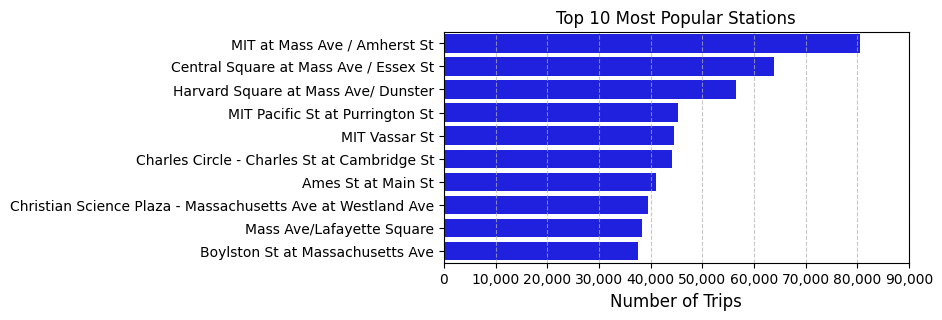

In [ ]:
# Most popular stations

# Count the number of trips per station
station_counts = combined_df["start_station_name"].value_counts()

# Get the top 10 most popular stations
top_10_stations = station_counts.head(10)

# Create a horizontal bar plot for the top 10 most popular stations
plt.figure(figsize=(6, 3))
sns.barplot(
    x=top_10_stations.values,
    y=top_10_stations.index,
    color='blue'
)

plt.xticks(ticks=plt.xticks()[0], labels=[f'{int(x):,}' for x in plt.xticks()[0]], rotation=0)

plt.title('Top 10 Most Popular Stations', fontsize=12)
plt.xlabel('Number of Trips', fontsize=12)
plt.ylabel("")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

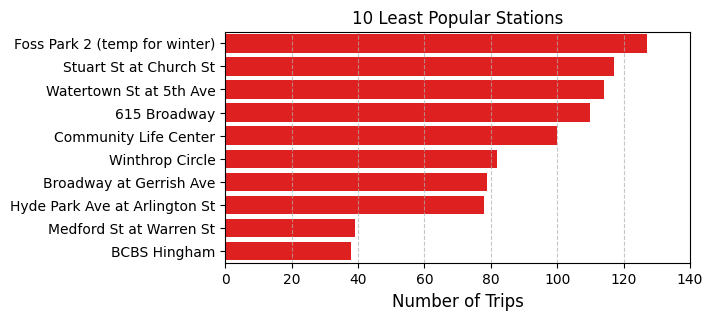

In [ ]:
# Least popular stations

# Get the 10 least popular stations (excluding those with zero trips)
least_10_stations = station_counts.tail(10)

# Create a horizontal bar plot for the 10 least popular stations
plt.figure(figsize=(6, 3))
sns.barplot(
    x=least_10_stations.values,
    y=least_10_stations.index,
    color='red'  # Use a solid color instead of a gradient
)

plt.xticks(ticks=plt.xticks()[0], labels=[f'{int(x):,}' for x in plt.xticks()[0]], rotation=0)

plt.title('10 Least Popular Stations', fontsize=12)
plt.xlabel('Number of Trips', fontsize=12)
plt.ylabel("")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

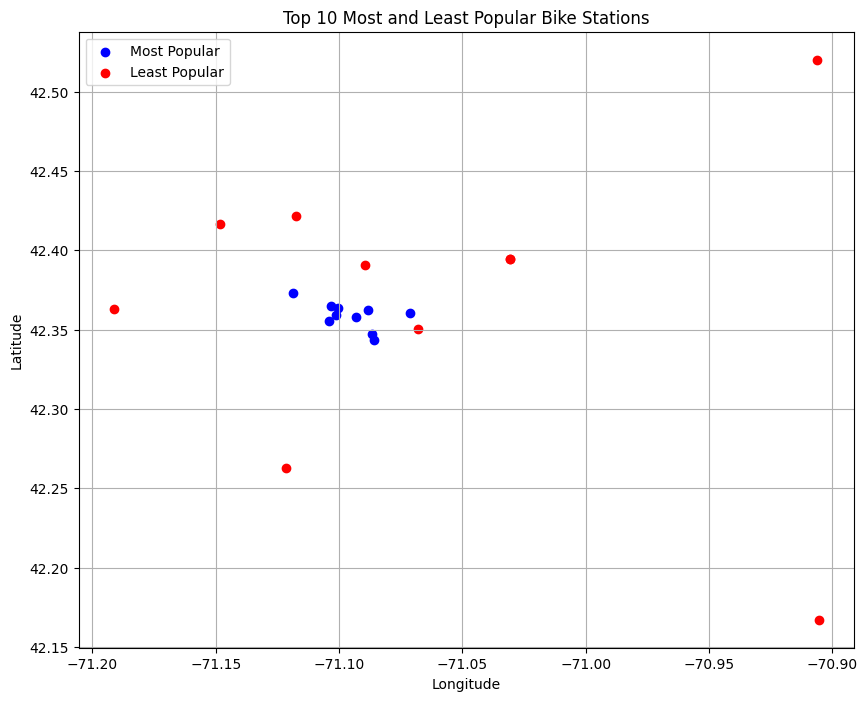

In [ ]:
# Create a new figure and axis
plt.figure(figsize=(10, 8))

# Plot the top 10 most popular stations
for station in top_10_stations.index:
    station_data = combined_df[combined_df["start_station_name"] == station]
    plt.scatter(station_data['start_lng'].iloc[0], station_data['start_lat'].iloc[0],
                color='blue', label='Most Popular' if station == top_10_stations.index[0] else "", alpha=1.0)

# Plot the least 10 popular stations
for station in least_10_stations.index:
    station_data = combined_df[combined_df["start_station_name"] == station]
    plt.scatter(station_data['start_lng'].iloc[0], station_data['start_lat'].iloc[0],
                color='red', label='Least Popular' if station == least_10_stations.index[0] else "", alpha=1.0)

# Add labels and title
plt.title('Top 10 Most and Least Popular Bike Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Show the plot
plt.grid()
plt.show()

In [ ]:
# Create a map centered at the mean coordinates of the stations
m = folium.Map(location=[combined_df['start_lat'].mean(), combined_df['start_lng'].mean()], zoom_start=13)

# Add markers for the top 10 most popular stations
for station in top_10_stations.index:
    station_data = combined_df[combined_df["start_station_name"] == station]
    folium.Marker(
        location=[station_data['start_lat'].iloc[0], station_data['start_lng'].iloc[0]],
        popup=f'Most Popular: {station}',
        icon=folium.Icon(color='blue')
    ).add_to(m)

# Add markers for the 10 least popular stations
for station in least_10_stations.index:
    station_data = combined_df[combined_df["start_station_name"] == station]
    folium.Marker(
        location=[station_data['start_lat'].iloc[0], station_data['start_lng'].iloc[0]],
        popup=f'Least Popular: {station}',
        icon=folium.Icon(color='red')
    ).add_to(m)

# Display the map
m

In [ ]:
# Top 10 most popular stations for electric and traditional bikes
for bike_type in ['electric', 'traditional']:
    top_10_stations = combined_df[combined_df['bike_type'] == bike_type].groupby('start_station_name').size().nlargest(10)

    # Add markers for the top 10 most popular stations of the bike type
    for station in top_10_stations.index:
        station_data = combined_df[(combined_df["start_station_name"] == station) & (combined_df['bike_type'] == bike_type)]
        folium.Marker(
            location=[station_data['start_lat'].iloc[0], station_data['start_lng'].iloc[0]],
            popup=f'{bike_type.capitalize()} Top 10: {station}',
            icon=folium.Icon(color='red' if bike_type == 'electric' else 'blue')
        ).add_to(m)

    # Add markers for the 10 least popular stations of the bike type
    least_10_stations = combined_df[combined_df['bike_type'] == bike_type].groupby('start_station_name').size().nsmallest(10)
    for station in least_10_stations.index:
        station_data = combined_df[(combined_df["start_station_name"] == station) & (combined_df['bike_type'] == bike_type)]
        folium.Marker(
            location=[station_data['start_lat'].iloc[0], station_data['start_lng'].iloc[0]],
            popup=f'{bike_type.capitalize()} Least 10: {station}',
            icon=folium.Icon(color='orange' if bike_type == 'electric' else 'green')
        ).add_to(m)

# Display the map
m

In [ ]:
# Top 10 station pairs
top_10_station_pairs = (combined_df.groupby(['start_station_name', 'end_station_name'])
                        .size()
                        .nlargest(10)
                        .reset_index(name='Count'))

top_10_station_pairs

,start_station_name,end_station_name,Count
0,MIT at Mass Ave / Amherst St,Beacon St at Massachusetts Ave,4615
1,MIT at Mass Ave / Amherst St,MIT Vassar St,4542
2,Beacon St at Massachusetts Ave,MIT at Mass Ave / Amherst St,4080
3,MIT Vassar St,MIT at Mass Ave / Amherst St,4053
4,MIT Vassar St,MIT Stata Center at Vassar St / Main St,4005
5,Central Square at Mass Ave / Essex St,MIT Pacific St at Purrington St,3894
6,MIT at Mass Ave / Amherst St,Central Square at Mass Ave / Essex St,3891
7,MIT Vassar St,Ames St at Main St,3733
8,MIT Pacific St at Purrington St,MIT Stata Center at Vassar St / Main St,3470
9,MIT Stata Center at Vassar St / Main St,MIT Vassar St,3466


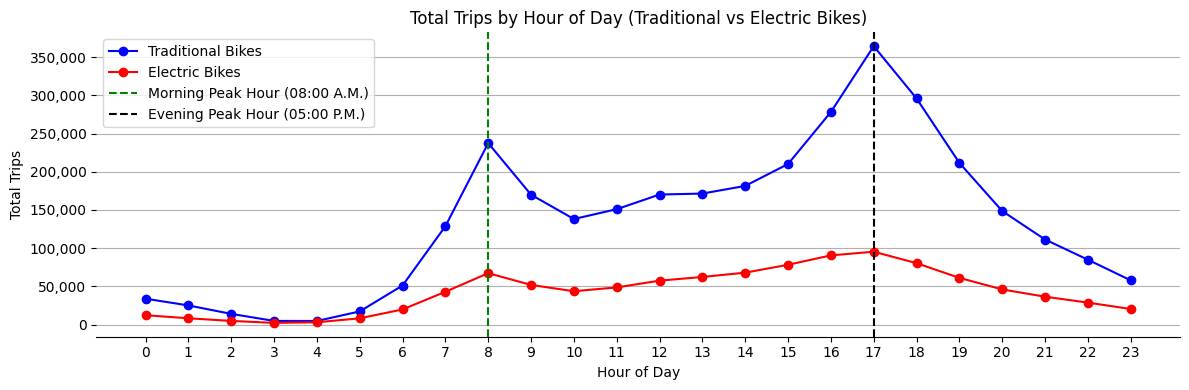

In [ ]:
# Filter data by bike type
traditionals = combined_df[combined_df["bike_type"] == "traditional"]
electrics = combined_df[combined_df["bike_type"] == "electric"]

# Extract hours for each bike type
traditionals["start_hour"] = traditionals["started_at"].dt.hour
electrics["start_hour"] = electrics["started_at"].dt.hour

# Group by hour of day and count trips for each bike type
traditional_hourly = traditionals.groupby("start_hour").size().reset_index(name="Total Start Trips")
electric_hourly = electrics.groupby("start_hour").size().reset_index(name="Total Start Trips")

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(traditional_hourly["start_hour"], traditional_hourly["Total Start Trips"], marker='o', color="blue", label="Traditional Bikes")
plt.plot(electric_hourly["start_hour"], electric_hourly["Total Start Trips"], marker='o', color="red", label="Electric Bikes")

# Set x-axis ticks to show every hour
plt.xticks(range(24))

# Show morning and evening peak indicators
plt.axvline(x=8, color='green', linestyle='--', label='Morning Peak Hour (08:00 A.M.)')
plt.axvline(x=17, color='black', linestyle='--', label='Evening Peak Hour (05:00 P.M.)')

# Add titles and labels
plt.title("Total Trips by Hour of Day (Traditional vs Electric Bikes)")
plt.xlabel("Hour of Day")
plt.ylabel("Total Trips")

# Customize grid, borders, yticks
plt.grid(axis='y')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

# Add legend and display plot
plt.legend()
plt.tight_layout()
plt.show()

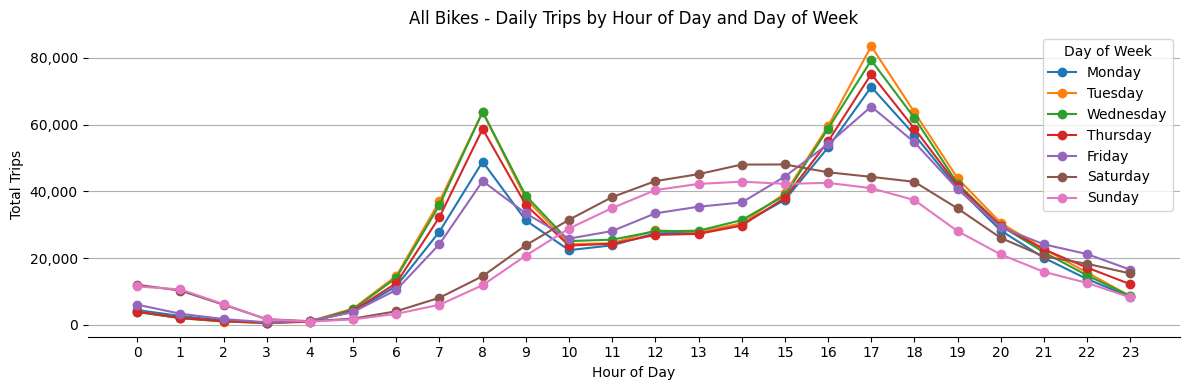

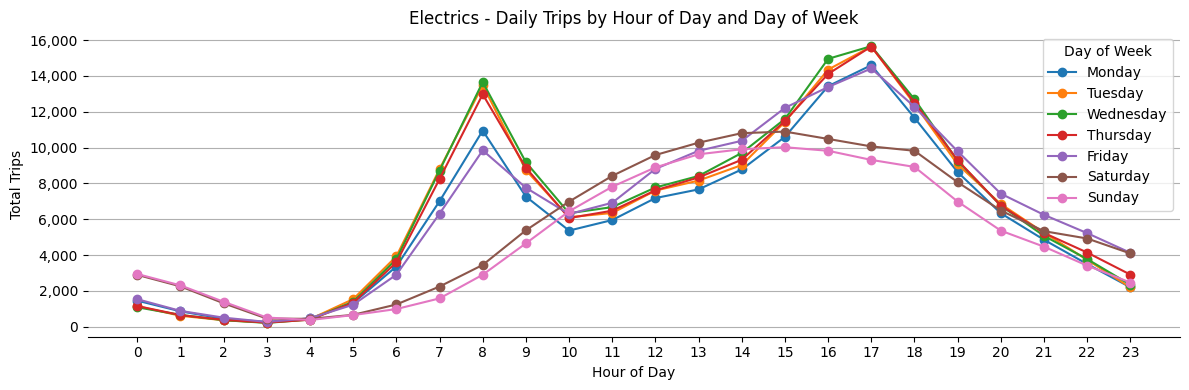

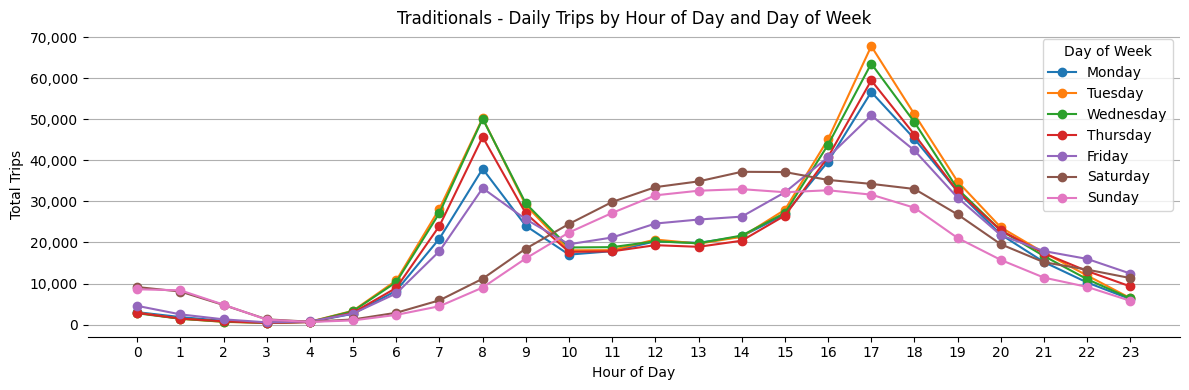

In [ ]:
def plot_daily_trips_by_hour_and_day(df, bike_type=None):
    # Filter data by bike type if specified
    if bike_type:
        df = df[df["bike_type"] == bike_type]

    # Extract day of the week and hour of the day
    df["start_day_of_week"] = df["started_at"].dt.day_name()
    df["start_hour"] = df["started_at"].dt.hour

    # Group by Day of the Week and Hour of Day to calculate total trips
    hourly_weekly_trip_starts = df.groupby(["start_day_of_week", "start_hour"]).size().unstack(fill_value=0)

    # Reorder the days of the week for proper visualization
    days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    hourly_weekly_trip_starts = hourly_weekly_trip_starts.reindex(days_order)

    # Plotting
    plt.figure(figsize=(12, 4))
    for day in hourly_weekly_trip_starts.index:
        plt.plot(hourly_weekly_trip_starts.columns, hourly_weekly_trip_starts.loc[day], marker='o', label=day)

    plt.xticks(range(24))
    plt.title(f"{bike_type.replace('_', ' ').title() + 's' if bike_type else 'All Bikes'} - Daily Trips by Hour of Day and Day of Week")
    plt.xlabel("Hour of Day")
    plt.ylabel("Total Trips")
    plt.grid(axis='y')

    # Format y-axis ticks to include commas
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x):,}'))

    # Remove plot boundaries at right, left, and top
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)

    plt.legend(title="Day of Week")
    plt.tight_layout()
    plt.show()

# Apply the function for all bikes, electric bikes, and traditional bikes
plot_daily_trips_by_hour_and_day(combined_df)
plot_daily_trips_by_hour_and_day(combined_df, bike_type="electric")
plot_daily_trips_by_hour_and_day(combined_df, bike_type="traditional")

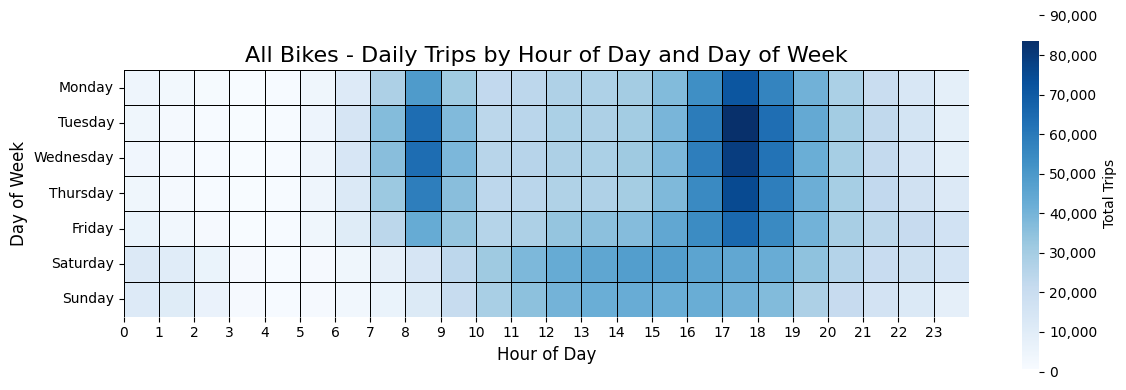

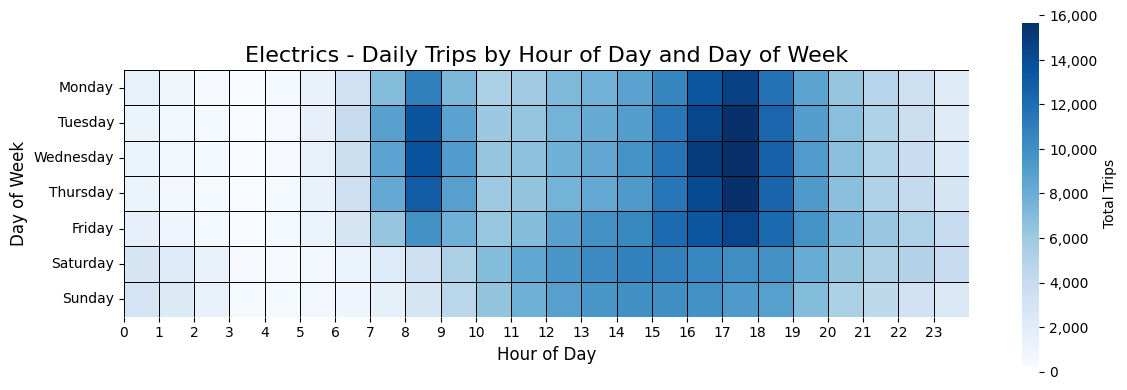

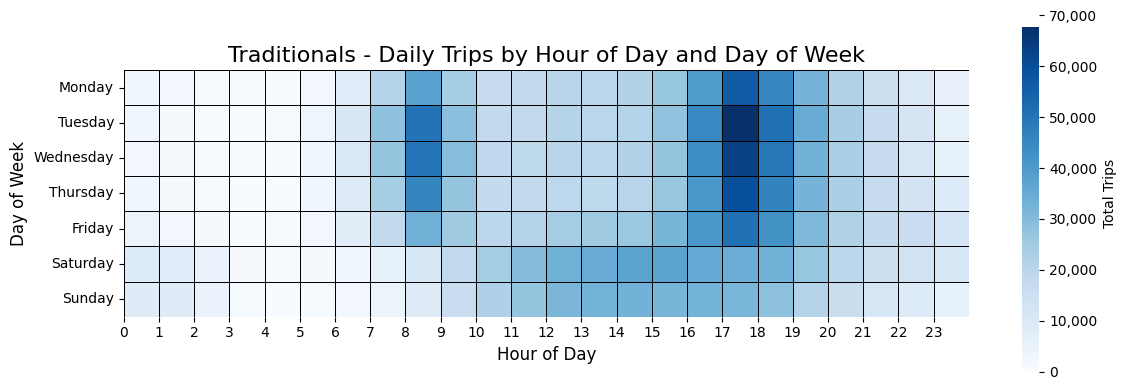

In [ ]:
def plot_daily_trips_heatmap(df, bike_type=None):
    # Filter data by bike type if specified
    if bike_type:
        df = df[df["bike_type"] == bike_type]

    # Extract day of the week and hour of the day
    df["start_day_of_week"] = df["started_at"].dt.day_name()
    df["start_hour"] = df["started_at"].dt.hour

    # Group by Day of the Week and Hour of Day to calculate total trips
    hourly_weekly_trip_starts = df.groupby(["start_day_of_week", "start_hour"]).size().unstack(fill_value=0)

    # Reorder the days of the week for proper visualization
    days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    hourly_weekly_trip_starts = hourly_weekly_trip_starts.reindex(days_order)

    # Plotting
    plt.figure(figsize=(12, 4))
    heatmap = sns.heatmap(hourly_weekly_trip_starts, cmap="Blues", annot=False, cbar_kws={'label': 'Total Trips'}, linewidths=0.5, linecolor='black', square=True)

    # Customize the plot
    title = f"{bike_type.replace('_', ' ').title() + 's' if bike_type else 'All Bikes'} - Daily Trips by Hour of Day and Day of Week"

    plt.title(title, fontsize=16)
    plt.xlabel("Hour of Day", fontsize=12)
    plt.ylabel("Day of Week", fontsize=12)

    # Set the x-ticks to show every hour
    plt.xticks(ticks=range(24), labels=range(24))

    # Remove plot boundaries at right, left, and top
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)

    # Format color bar ticks with commas
    colorbar = heatmap.collections[0].colorbar
    colorbar.set_ticks(colorbar.get_ticks())
    colorbar.ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{x:,.0f}'))

    # Layout adjustments
    plt.tight_layout()
    plt.show()

# Apply the function for all bikes, electric bikes, and traditional bikes
plot_daily_trips_heatmap(combined_df)
plot_daily_trips_heatmap(combined_df, bike_type="electric")
plot_daily_trips_heatmap(combined_df, bike_type="traditional")

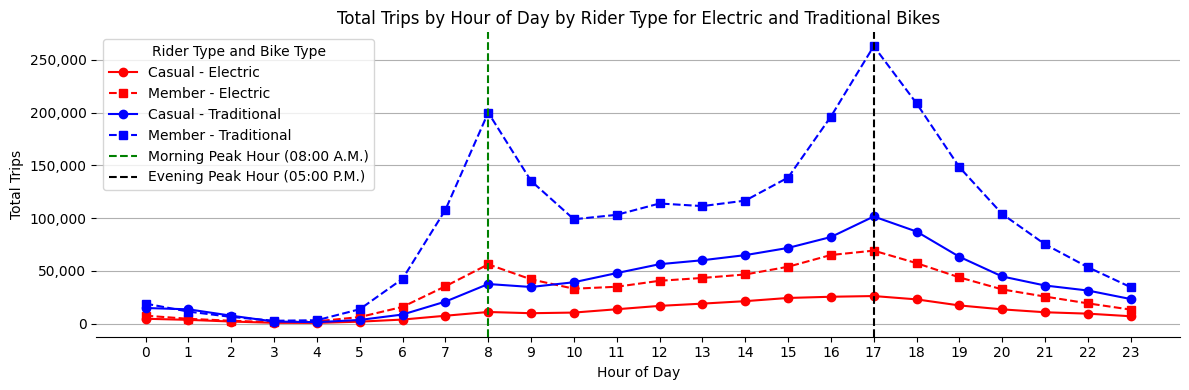

In [ ]:
# Function to plot trips by hour of day, separated by bike type
def plot_daily_trips_by_hour_and_rider_type(df):
    # Extract hour of the day and rider type
    df["start_hour"] = df["started_at"].dt.hour

    # Group by Hour of Day, Rider Type, and Bike Type to calculate total trips
    hourly_trip_starts_by_rider_type = df.groupby(["start_hour", "rider_type", "bike_type"]).size().unstack(fill_value=0)

    # Plotting
    plt.figure(figsize=(12, 4))

    # Define colors for different bike types
    bike_type_colors = {
        "traditional": "blue",
        "electric": "red"
    }

    # Define line styles for casual and member rider types
    rider_type_line_styles = {
        "casual": "solid",  # Solid line for casual riders
        "member": "dashed"  # Dashed line for member riders
    }

    # Define markers for each rider type
    rider_type_markers = {
        "casual": "o",  # Circle marker for casual riders
        "member": "s"   # Square marker for member riders
    }

    # Plot separate lines for each bike type, with rider types in the legend
    for bike_type in hourly_trip_starts_by_rider_type.columns:
        for rider_type in hourly_trip_starts_by_rider_type.index.get_level_values(1).unique():
            # Filter data by bike type and rider type
            data = hourly_trip_starts_by_rider_type.loc[(slice(None), rider_type, slice(None)), bike_type].values

            # Get corresponding hours
            hours = hourly_trip_starts_by_rider_type.loc[(slice(None), rider_type, slice(None)), bike_type].index.get_level_values(0)

            # Plot with line style and marker
            plt.plot(
                hours,
                data,
                label=f"{rider_type.capitalize()} - {bike_type.replace('_', ' ').title()}",
                color=bike_type_colors.get(bike_type),
                linestyle=rider_type_line_styles.get(rider_type, "solid"),
                marker=rider_type_markers.get(rider_type, "o")
            )

    # Set x-axis ticks to show every hour
    plt.xticks(range(24))

    # Format y-axis to display numbers with commas
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))

    # Show morning and evening peak indicators
    plt.axvline(x=8, color='green', linestyle='--', label='Morning Peak Hour (08:00 A.M.)')
    plt.axvline(x=17, color='black', linestyle='--', label='Evening Peak Hour (05:00 P.M.)')

    # Add titles and labels
    plt.title("Total Trips by Hour of Day by Rider Type for Electric and Traditional Bikes")
    plt.xlabel("Hour of Day")
    plt.ylabel("Total Trips")

    # Remove vertical grid lines
    plt.grid(axis='y')

    # Remove plot boundaries at right, left, and top
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)

    # Legend customization
    plt.legend(title="Rider Type and Bike Type")

    # Layout adjustments
    plt.tight_layout()
    plt.show()

# Apply the function for all bikes
plot_daily_trips_by_hour_and_rider_type(combined_df)

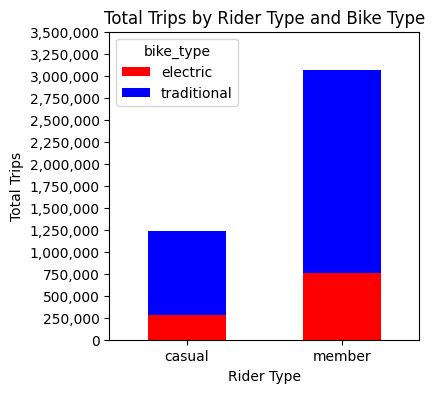

In [ ]:
# Group by rider_type and bike_type and count the number of trips
rider_type_analysis = combined_df.groupby(['rider_type', 'bike_type']).size().unstack()

# Plot stacked bar chart with specific colors
ax = rider_type_analysis.plot(kind='bar', stacked=True, color=['red', 'blue'], figsize=(4, 4))

# Customize plot labels and title
ax.set_title("Total Trips by Rider Type and Bike Type")
ax.set_ylabel("Total Trips")
ax.set_xlabel("Rider Type")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Set y-ticks in multiples of 25,000
ax.set_yticks(range(0, int(rider_type_analysis.sum().max()) + 250_000, 250_000))

# Ensure y-axis labels are not in scientific notation
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.show()

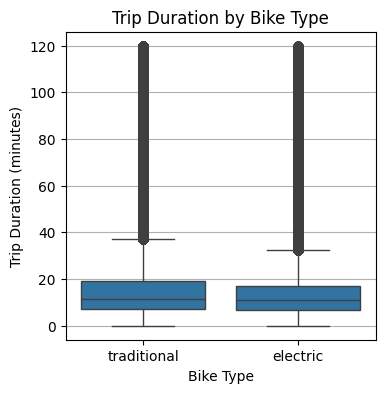

In [ ]:
# BOXPLOT FOR TRIP DURATION BY BIKE TYPE

plt.figure(figsize=(4, 4))
sns.boxplot(x='bike_type', y='trip_duration_minutes', data=combined_df)
plt.title("Trip Duration by Bike Type")
plt.ylabel("Trip Duration (minutes)")
plt.xlabel("Bike Type")
plt.grid(axis='y')
# Show the plot

plt.show()

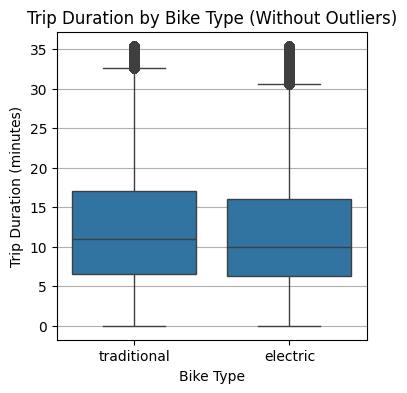

In [ ]:
# BOXPLOT FOR TRIP DURATION BY BIKE TYPE WITHOUT OUTLIERS

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = combined_df['trip_duration_minutes'].quantile(0.25)
Q3 = combined_df['trip_duration_minutes'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataframe to exclude outliers
filtered_df = combined_df[(combined_df['trip_duration_minutes'] >= lower_bound) & (combined_df['trip_duration_minutes'] <= upper_bound)]

# Boxplot for Trip Duration by Bike Type without outliers
plt.figure(figsize=(4, 4))
sns.boxplot(x='bike_type', y='trip_duration_minutes', data=filtered_df)
plt.title("Trip Duration by Bike Type (Without Outliers)")
plt.xlabel("Bike Type")
plt.ylabel("Trip Duration (minutes)")
plt.grid(axis='y')
plt.show()

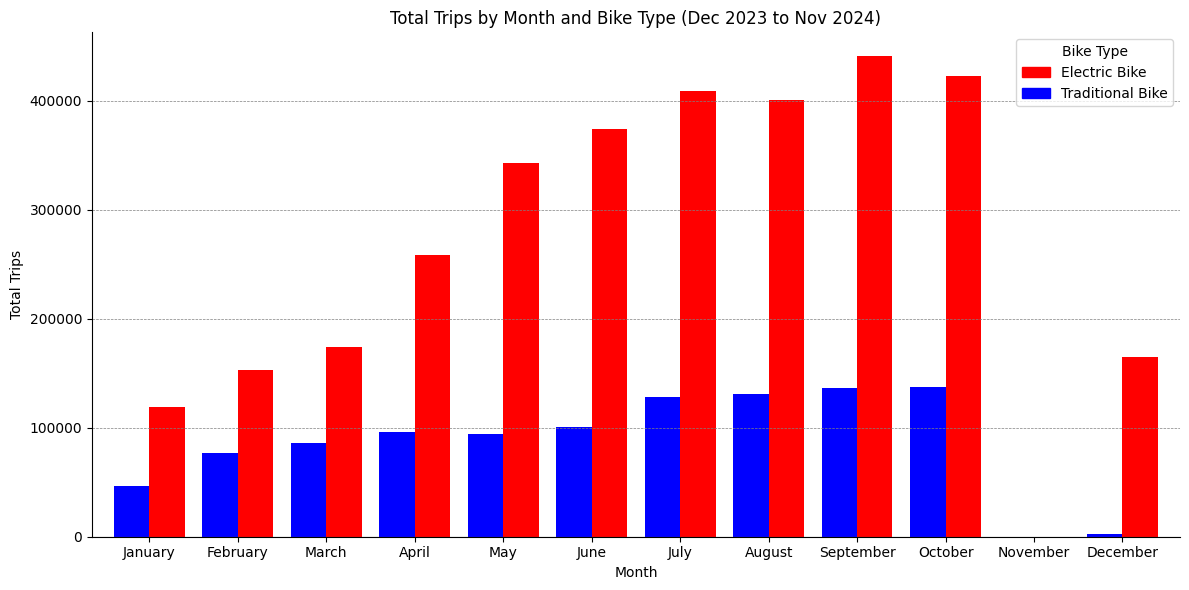

In [ ]:
# Extract the month the trips started
combined_df["start_month"] = combined_df["started_at"].dt.month_name()

# Count total trips by month and bike type
monthly_trip_counts = combined_df.groupby(["start_month", "bike_type"]).size().unstack(fill_value=0).reindex(
    ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"],
    fill_value=0
)

# Plotting side-by-side bar chart
plt.figure(figsize=(12, 6))
monthly_trip_counts.plot(kind='bar', color=['blue', 'red'], width=0.8, ax=plt.gca())

# Customize plot labels and title
plt.title("Total Trips by Month and Bike Type (Dec 2023 to Nov 2024)")
plt.xlabel("Month")
plt.ylabel("Total Trips")
plt.xticks(rotation=0)

# Add a horizontal line at y=0 for better visibility
plt.axhline(0, color='gray', linewidth=0.8)

# Add grid lines
plt.grid(axis='y', linestyle='--', color='gray', linewidth=0.5)

# Custom legend with markers
traditional_patch = mpatches.Patch(color='blue', label='Traditional Bike')
electric_patch = mpatches.Patch(color='red', label='Electric Bike')
plt.legend(handles=[electric_patch, traditional_patch], title="Bike Type")

# Remove plot boundaries at right, left, and top
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Tight layout for better spacing
plt.tight_layout()
plt.show()

In [ ]:
# Descriptive statistics for trip duration, grouped by bike type
combined_df.groupby('bike_type')['trip_duration_minutes'].describe()

,count,mean,std,min,25%,50%,75%,max
bike_type,,,,,,,,
electric,1036776.0,13.943130,12.360753,0.0,6.7,10.900000,17.0,120.0
traditional,3261421.0,15.143493,13.418903,0.0,7.0,11.266667,19.0,120.0


In [ ]:
# Descriptive statistics for trip duration, grouped by rider type
combined_df.groupby('rider_type')['trip_duration_minutes'].describe()

,count,mean,std,min,25%,50%,75%,max
rider_type,,,,,,,,
casual,1238809.0,20.982021,18.003491,0.0,9.383333,16.0,26.0,120.0
member,3059388.0,12.372571,9.565433,0.0,6.000000,10.0,16.0,120.0


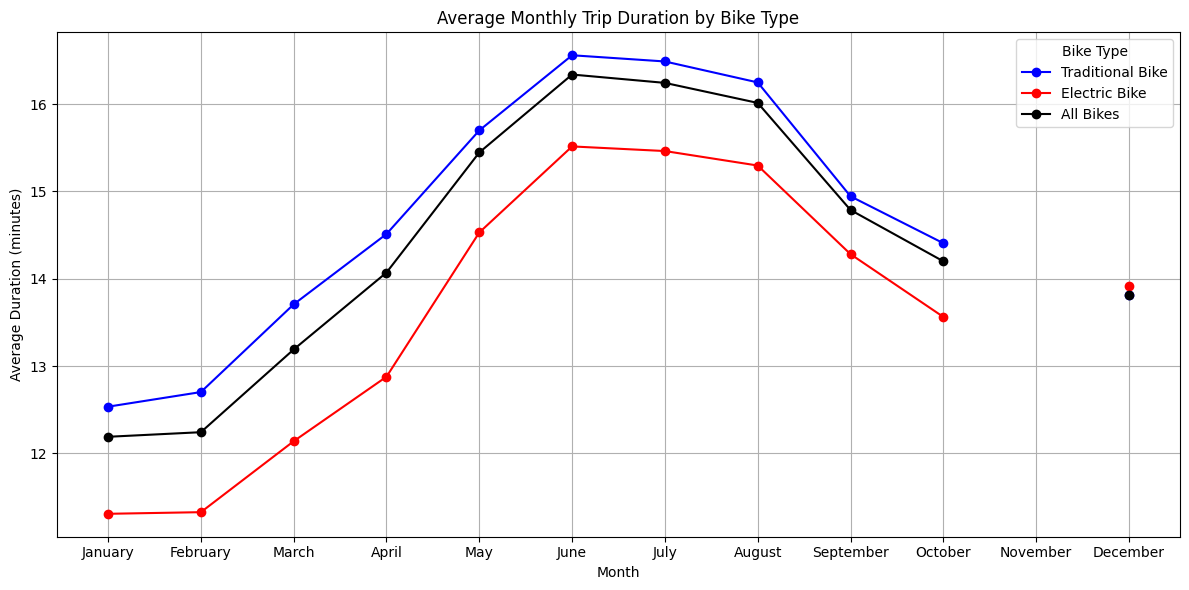

In [ ]:
# Calculate avg trip duration by bike type/month
average_duration = combined_df.groupby(['start_month', 'bike_type'])['trip_duration_minutes'].mean().unstack()

# Rename columns
average_duration.columns = ['electric', 'traditional']

# Define month order
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

# Reindex DataFrame
average_duration = average_duration.reindex(month_order)

# Calculate total average duration (mean of electric and traditional)
average_duration['total'] = combined_df.groupby('start_month')['trip_duration_minutes'].mean()

# Plot avg trip duration
plt.figure(figsize=(12, 6))
plt.plot(average_duration.index, average_duration['traditional'], marker='o', label='Traditional Bike', color='blue')
plt.plot(average_duration.index, average_duration['electric'], marker='o', label='Electric Bike', color='red')
plt.plot(average_duration.index, average_duration['total'], marker='o', label='All Bikes', color='black')

plt.title('Average Monthly Trip Duration by Bike Type')
plt.xlabel('Month')
plt.ylabel('Average Duration (minutes)')

plt.xticks(rotation=0)

plt.grid(True)
plt.legend(title='Bike Type')
plt.tight_layout()
plt.show()

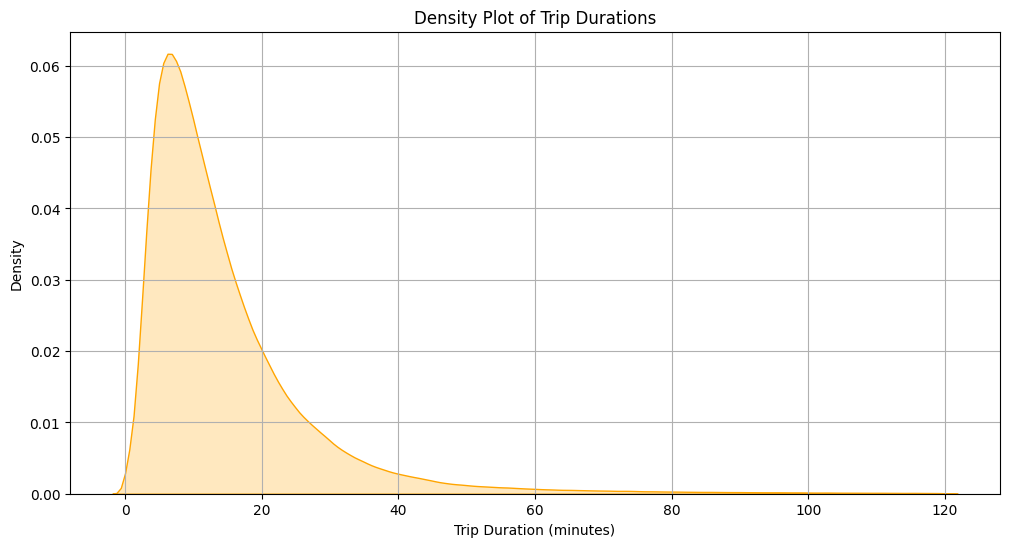

In [ ]:
# Trip Duration Distribution (Density Plot)
plt.figure(figsize=(12, 6))
sns.kdeplot(trip_duration_minutes, color='orange', fill=True)
plt.title('Density Plot of Trip Durations')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Density')
plt.grid()
plt.show()

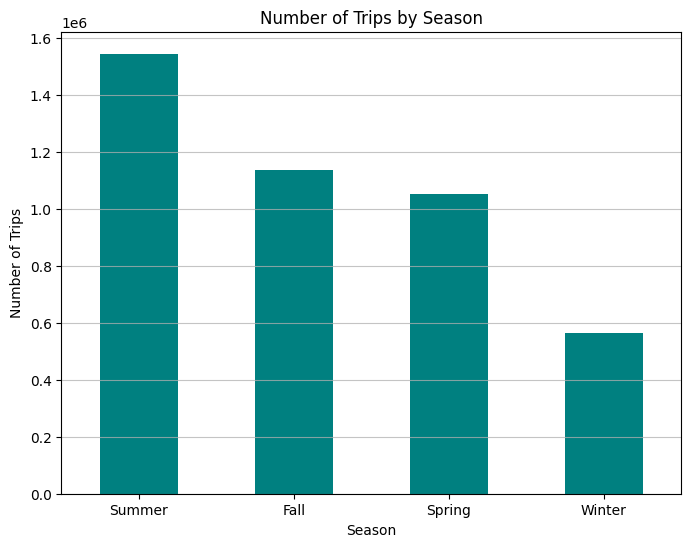

In [ ]:
# Trips by Season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

combined_df['season'] = combined_df['started_at'].dt.month.apply(get_season)

plt.figure(figsize=(8, 6))
seasonal_trips = combined_df['season'].value_counts()
seasonal_trips.plot(kind='bar', color='teal')
plt.title('Number of Trips by Season')
plt.xlabel('Season')
plt.ylabel('Number of Trips')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
# How many trips started at station with ID "D32032"
combined_df[combined_df['start_station_id'] == 'D32032'].shape[0]

18094

In [ ]:
# Count trips starting at each station (checkouts)
checkouts = combined_df.groupby('start_station_id').size().reset_index(name='bikes_checked_out')

# Count trips ending at each station (returns)
returns = combined_df.groupby('end_station_id').size().reset_index(name='bikes_returned')

# Merge the two counts on station ID
station_usage = pd.merge(checkouts, returns, left_on='start_station_id', right_on='end_station_id', how='outer').fillna(0)

# Rename the columns for clarity
station_usage.rename(columns={'start_station_id': 'station_id'}, inplace=True)

# Calculate the difference (checkouts - returns)
station_usage['usage_difference'] = station_usage['bikes_checked_out'] - station_usage['bikes_returned']

# Calculate imbalance severity
station_usage['imbalance'] = abs(station_usage['usage_difference'])

# Identify stations with more checkouts, more returns, and balanced usage
more_checkouts = station_usage[station_usage['usage_difference'] > 0]
more_returns = station_usage[station_usage['usage_difference'] < 0]
balanced_usage = station_usage[station_usage['usage_difference'] == 0]

# Thresholds for "jammed" and "empty" stations
jammed_stations = station_usage[station_usage['usage_difference'] < -10]  # More returns
empty_stations = station_usage[station_usage['usage_difference'] > 10]    # More checkouts

# Display top jammed and empty stations based on imbalance severity
top_jammed = jammed_stations.sort_values(by='imbalance', ascending=False).head(10)
top_empty = empty_stations.sort_values(by='imbalance', ascending=False).head(10)

# Results for total stations with more checkouts, more returns, and balanced usage
print(f"Total stations with more checkouts: {len(more_checkouts)}")
print(f"Total stations with more returns: {len(more_returns)}")
print(f"Total stations with balanced usage: {len(balanced_usage)}")

Total stations with more checkouts: 216
Total stations with more returns: 300
Total stations with balanced usage: 2


In [ ]:
# Top jammed stations
print("\nTop 10 jammed stations (more bikes returned than checked out):\n")
(top_jammed[['station_id', 'bikes_checked_out', 'bikes_returned', 'usage_difference', 'imbalance']])


Top 10 jammed stations (more bikes returned than checked out):



,station_id,bikes_checked_out,bikes_returned,usage_difference,imbalance
352,M32037,41067,46433,-5366,5366
4,A32004,24482,26337,-1855,1855
334,M32018,56469,58192,-1723,1723
207,D32007,22451,24166,-1715,1715
132,C32034,16361,18056,-1695,1695
84,B32037,24037,25620,-1583,1583
89,B32058,16578,18119,-1541,1541
333,M32017,21385,22811,-1426,1426
18,A32025,24319,25721,-1402,1402
33,A32042,15764,17163,-1399,1399


In [ ]:
# Top empty stations
print("\nTop 10 empty stations (more bikes checked out than returned):\n")
top_empty[['station_id', 'bikes_checked_out', 'bikes_returned', 'usage_difference', 'imbalance']]


Top 10 empty stations (more bikes checked out than returned):



,station_id,bikes_checked_out,bikes_returned,usage_difference,imbalance
357,M32042,44637,40777,3860,3860
79,B32032,23413,19918,3495,3495
386,M32071,24532,22070,2462,2462
342,M32026,18207,15778,2429,2429
250,D32054,5413,3275,2138,2138
378,M32063,24296,22409,1887,1887
431,S32001,6164,4408,1756,1756
83,B32036,12300,10547,1753,1753
356,M32041,45373,43743,1630,1630
94,B32063,14353,12748,1605,1605


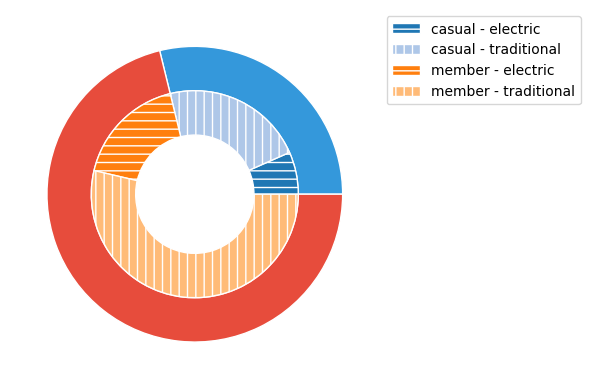

In [ ]:
# Prepare the data
grouped_data = combined_df.groupby(['rider_type', 'bike_type']).size().unstack(fill_value=0)

# Data for inner ring (rider_type)
rider_type_sizes = grouped_data.sum(axis=1)

# Data for outer ring (bike_type within rider_type)
bike_type_sizes = grouped_data.values.flatten()

# Define colors for both inner and outer rings
inner_colors = ['#3498db', '#e74c3c']
outer_colors = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78']

# Define hatches for bike_type
outer_hatches = ['--', '||', '--', '||']

# Create the pie chart
fig, ax = plt.subplots()

# Plot the inner ring (rider_type)
ax.pie(rider_type_sizes, colors=inner_colors, radius=1,
       wedgeprops=dict(width=0.3, edgecolor='w'))

# Plot the outer ring (bike_type) with textures
patches, texts = ax.pie(bike_type_sizes, colors=outer_colors, radius=0.7,
                        wedgeprops=dict(width=0.3, edgecolor='w'),
                        hatch=outer_hatches)

# Legend
bike_type_labels = [f'{rider} - {bike}' for rider in grouped_data.index for bike in grouped_data.columns]
plt.legend(patches, bike_type_labels, loc='upper left', bbox_to_anchor=(1, 0, 0.5, 1))

# Equal aspect ratio
ax.set(aspect="equal")

plt.show()

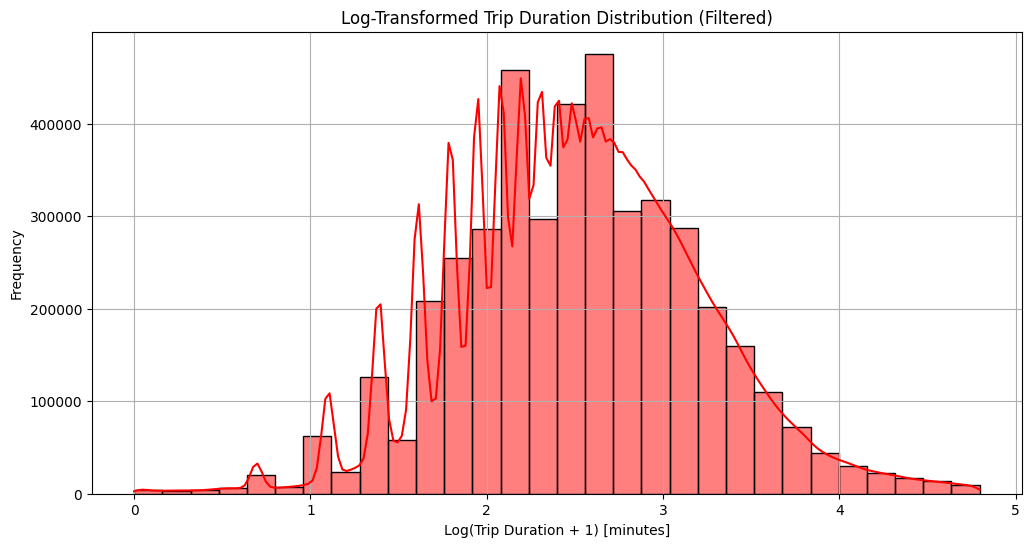

In [ ]:
# Trip Duration Distribution (Histogram with Log Transformation)
plt.figure(figsize=(12, 6))
sns.histplot(np.log(trip_duration_minutes + 1), bins=30, color='red', kde=True)

plt.title('Log-Transformed Trip Duration Distribution (Filtered)')
plt.xlabel('Log(Trip Duration + 1) [minutes]')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# Check the number of trips for each bike type
e_bike_count = combined_df[combined_df['bike_type'] == 'electric'].shape[0]
traditional_bike_count = combined_df[combined_df['bike_type'] == 'traditional'].shape[0]

print(f"E-bike trips count: {e_bike_count}")
print(f"Traditional bike trips count: {traditional_bike_count}")

E-bike trips count: 1036776
Traditional bike trips count: 3261421


In [ ]:
# Function to calculate z-statistic and p-value for two-sample z-test
def two_sample_z_test(mean_1, mean_2, var_1, var_2, n_1, n_2):
    std_1, std_2 = math.sqrt(var_1), math.sqrt(var_2)
    z = (mean_1 - mean_2) / math.sqrt((std_1**2 / n_1) + (std_2**2 / n_2))
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))  # Two-tailed p-value
    return z, p_value

# Function to calculate confidence interval for the difference of means
def confidence_interval(mean_1, mean_2, var_1, var_2, n_1, n_2, confidence_level=0.95):
    std_1, std_2 = math.sqrt(var_1), math.sqrt(var_2)
    z_critical = stats.norm.ppf(1 - (1 - confidence_level) / 2)
    margin_of_error = z_critical * math.sqrt((std_1**2 / n_1) + (std_2**2 / n_2))
    difference_in_means = mean_1 - mean_2
    ci_lower = difference_in_means - margin_of_error
    ci_upper = difference_in_means + margin_of_error
    return ci_lower, ci_upper

# Data for e-bikes and traditional bikes
mean_e_bike, mean_traditional_bike = 13.95, 15.15
var_e_bike, var_traditional_bike = 152.96, 180.15
n_e_bike, n_traditional_bike = 1038644, 3265180

# Perform z-test
z_statistic, p_value = two_sample_z_test(mean_e_bike, mean_traditional_bike, var_e_bike, var_traditional_bike, n_e_bike, n_traditional_bike)

# Calculate the confidence interval for the difference in means
ci_lower, ci_upper = confidence_interval(mean_e_bike, mean_traditional_bike, var_e_bike, var_traditional_bike, n_e_bike, n_traditional_bike)

# Output results and hypothesis decision
alpha = 0.05
print(f"Z-statistic: {z_statistic}\nP-value: {p_value}")
print("Reject H₀: Significant difference." if p_value < alpha else "Fail to reject H₀: No significant difference.")
print(f"95% Confidence Interval for the Difference in Means: ({ci_lower}, {ci_upper})")

Z-statistic: -84.339481784081
P-value: 0.0
Reject H₀: Significant difference.
95% Confidence Interval for the Difference in Means: (-1.2278867824617354, -1.1721132175382667)


In [ ]:
# Filter data for electric bikes and traditional bikes
electric_bike_data = combined_df[combined_df['bike_type'] == 'electric']
traditional_bike_data = combined_df[combined_df['bike_type'] == 'traditional']

# Perform ANOVA for e-bikes and traditional bikes separately
# For e-bikes, group by 'season' and get the trip duration
e_bike_seasonal_data = electric_bike_data.groupby('season')['trip_duration_minutes'].apply(list)

# For traditional bikes, group by 'season' and get the trip duration
traditional_bike_seasonal_data = traditional_bike_data.groupby('season')['trip_duration_minutes'].apply(list)

# Perform ANOVA test for e-bikes
e_bike_f_statistic, e_bike_p_value = stats.f_oneway(*e_bike_seasonal_data)

# Perform ANOVA test for traditional bikes
traditional_bike_f_statistic, traditional_bike_p_value = stats.f_oneway(*traditional_bike_seasonal_data)

# Output the results for e-bikes and traditional bikes
print(f"E-Bikes - F-statistic: {e_bike_f_statistic}, P-value: {e_bike_p_value}")
print(f"Traditional Bikes - F-statistic: {traditional_bike_f_statistic}, P-value: {traditional_bike_p_value}")

# Decision based on p-value
alpha = 0.05

# E-bike results
if e_bike_p_value < alpha:
    print("Reject the null hypothesis for e-bikes: There is a significant difference in trip durations across seasons.")
else:
    print("Fail to reject the null hypothesis for e-bikes: There is no significant difference in trip durations across seasons.")

# Traditional bike results
if traditional_bike_p_value < alpha:
    print("Reject the null hypothesis for traditional bikes: There is a significant difference in trip durations across seasons.")
else:
    print("Fail to reject the null hypothesis for traditional bikes: There is no significant difference in trip durations across seasons.")

E-Bikes - F-statistic: 3885.003323889877, P-value: 0.0
Traditional Bikes - F-statistic: 7600.556666187359, P-value: 0.0
Reject the null hypothesis for e-bikes: There is a significant difference in trip durations across seasons.
Reject the null hypothesis for traditional bikes: There is a significant difference in trip durations across seasons.


In [ ]:
combined_df.head()

,ride_id,bike_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,rider_type,trip_duration_minutes,start_station_number,end_station_number,start_day_of_week,start_hour,start_month,season
0,31F12D722DEC2205,traditional,2023-12-01 00:00:47,2023-12-01 00:18:32,MIT Carleton St at Amherst St,M32070,Lower Cambridgeport at Magazine St / Riverside Rd,M32022,42.360541,-71.086698,42.357219,-71.113872,member,17.750000,M32070,M32022,Friday,0,December,Winter
1,C7B5105B0B65C0F3,traditional,2023-12-01 00:02:04,2023-12-01 00:07:54,MIT at Mass Ave / Amherst St,M32006,MIT Vassar St,M32042,42.358100,-71.093198,42.355601,-71.103945,member,5.833333,M32006,M32042,Friday,0,December,Winter
2,68B5F2A512F98D31,traditional,2023-12-01 00:02:11,2023-12-01 00:03:15,South Station - 700 Atlantic Ave,A32010,Boston Landing,A32045,42.352175,-71.055547,42.356561,-71.141675,member,1.066667,A32010,A32045,Friday,0,December,Winter
3,498C4A8C729ED986,traditional,2023-12-01 00:04:19,2023-12-01 00:14:00,One Beacon St,B32061,Columbus Ave at W. Canton St,C32077,42.358477,-71.061351,42.344742,-71.076482,member,9.683333,B32061,C32077,Friday,0,December,Winter
4,2B9A06F84509E2C0,traditional,2023-12-01 00:04:38,2023-12-01 00:16:16,Silber Way,D32032,Dartmouth St at Newbury St,D32045,42.349495,-71.100575,42.350961,-71.077828,member,11.633333,D32032,D32045,Friday,0,December,Winter
